# Decision Trees & CART — Machine Learning Labs
### Learning objectives:
- Understand how Decision Trees work (CART)
- Train and interpret DecisionTreeClassifier and DecisionTreeRegressor
- Diagnose and prevent overfitting
- Understand impurity measures: Gini vs Entropy
- Explore pruning, feature importance, decision boundaries
- Complete practical hands-on exercises on real and synthetic datasets

## 1. Introduction to Decision Trees

A Decision Tree is a model that predicts values by asking a sequence of yes/no questions.
Each internal node represents a condition (a decision rule), while leaves represent predictions.

Key properties:
- Interpretable structure
- Requires little data preprocessing
- Works for classification and regression
- Prone to **overfitting** without regularization

Decision Trees in scikit-learn use the **CART algorithm**.


## 2. CART: Classification and Regression Trees

CART builds:
- **binary decision trees** (always 2 splits)
- for both classification and regression
- using impurity minimization and greedy splitting

### Impurity for classification:

**Gini impurity:**
\[
G = \sum_k p_k (1 - p_k)
\]

**Entropy:**
\[
H = - \sum_k p_k \log_2(p_k)
\]

### Impurity for regression:

- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)

CART uses **greedy splitting**, so it does not find globally optimal trees → strong tendency to overfit.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance

from mlxtend.plotting import plot_decision_regions

In [2]:
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## 3. Training a basic Decision Tree (no regularization)


In [3]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



## 4. Visualizing the Decision Tree
A major advantage of trees is interpretability. Let's visualize the full tree.

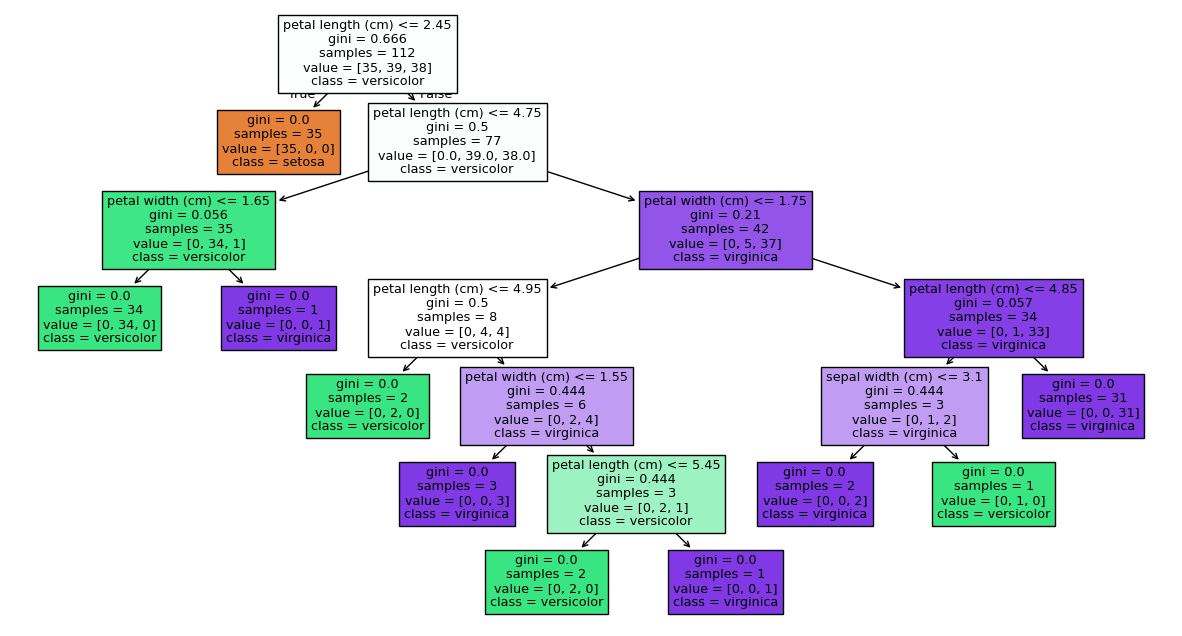

In [5]:
plt.figure(figsize=(15,8))
plot_tree(
    clf, 
    feature_names=X.columns, 
    class_names=data.target_names, 
    filled=True
)
plt.show()

## 5. Overfitting in Decision Trees

Unconstrained trees grow until leaves are perfectly pure → 100% accuracy on training data.

Effects:
- Very poor generalization
- High model variance

Let's demonstrate this.

In [6]:
clf_unrestricted = DecisionTreeClassifier(random_state=42)
clf_unrestricted.fit(X_train, y_train)

print("Train accuracy:", clf_unrestricted.score(X_train, y_train))
print("Test accuracy :", clf_unrestricted.score(X_test, y_test))

Train accuracy: 1.0
Test accuracy : 1.0


## 6. Regularization in CART

Main hyperparameters that control tree size:

- `max_depth`
- `min_samples_leaf`
- `min_samples_split`
- `max_leaf_nodes`

Below we test different `max_depth` values.

In [8]:
for depth in [1, 2, 3, 4, 5, None]:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(f"depth={depth}, test accuracy={acc:.3f}")

depth=1, test accuracy=0.684
depth=2, test accuracy=0.974
depth=3, test accuracy=1.000
depth=4, test accuracy=1.000
depth=5, test accuracy=1.000
depth=None, test accuracy=1.000


## 7. Feature Importance (impurity-based)

CART assigns higher importance to features used more often in splits.

Note: impurity-based importance can be biased toward numerical features or features with many split points.


In [9]:
importances = clf.feature_importances_
pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values("importance", ascending=False)


,feature,importance
2,petal length (cm),0.899746
3,petal width (cm),0.082378
1,sepal width (cm),0.017876
0,sepal length (cm),0.000000


## 8. Permutation Importance

A more trustworthy importance measure:
- Randomly shuffle a feature
- Measure how much the model's accuracy drops

This gives *true predictive contribution*.


In [10]:
perm = permutation_importance(clf, X_test, y_test, n_repeats=10)
sorted_idx = perm.importances_mean.argsort()

for idx in sorted_idx[::-1]:
    print(f"{X.columns[idx]}: {perm.importances_mean[idx]:.4f}")

petal length (cm): 0.5000
petal width (cm): 0.1132
sepal width (cm): 0.0000
sepal length (cm): 0.0000


## 9. Gini vs Entropy — Understanding impurity measures


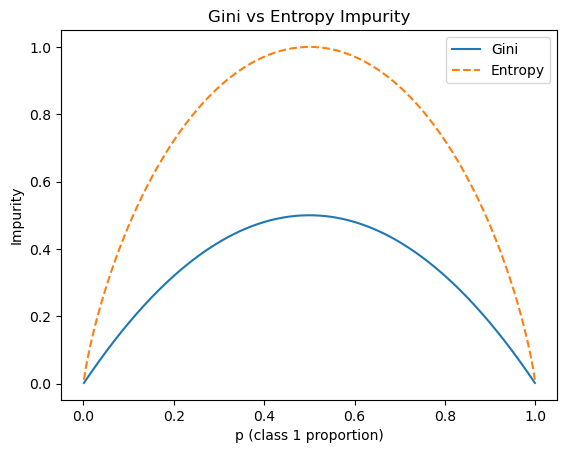

In [11]:
p = np.linspace(0.001, 0.999, 300)
gini = 2 * p * (1 - p)
entropy = -(p*np.log2(p) + (1-p)*np.log2(1-p))

plt.plot(p, gini, label="Gini")
plt.plot(p, entropy, linestyle="--", label="Entropy")
plt.xlabel("p (class 1 proportion)")
plt.ylabel("Impurity")
plt.legend()
plt.title("Gini vs Entropy Impurity")
plt.show()


## 10. Decision Boundaries Visualization (2D)

Here we restrict ourselves to 2 features and illustrate how CART divides the feature space.


C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


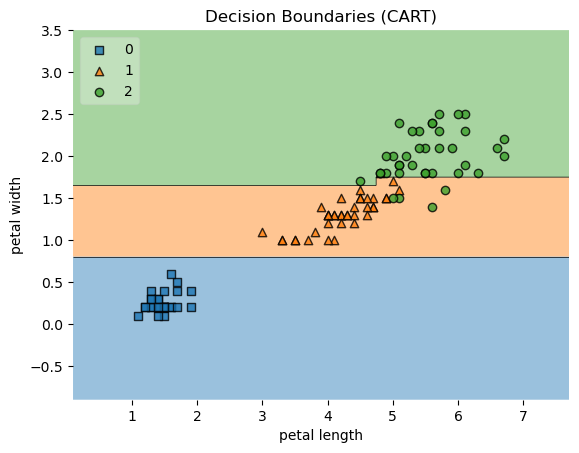

In [15]:
X2 = X_train[["petal length (cm)", "petal width (cm)"]]
clf_2d = DecisionTreeClassifier(max_depth=3).fit(X2, y_train)

plot_decision_regions(X2.values, y_train, clf=clf_2d, legend=2)
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.title("Decision Boundaries (CART)")
plt.show()

## Cost-Complexity Pruning (CCP) — Summary

**Goal:** Reduce overfitting by simplifying the decision tree.

CART prunes trees by minimizing:

\[
R_\alpha(T) = R(T) + \alpha \cdot |T|
\]

Where:
- \(R(T)\) = model error,
- \(|T|\) = number of leaves,
- \(\alpha\) = penalty for model complexity.

**How it works:**
1. Start with a fully grown tree (often overfitted).
2. Compute `ccp_alpha` values at which subtrees can be removed.
3. For each α:
   - prune the tree,
   - evaluate performance.
4. Choose the α that gives the best validation accuracy.

**Interpretation of the pruning curve:**
- **Low α** → large, complex tree (risk of overfitting).
- **Medium α** → balanced tree (often best performance).
- **High α** → overly small tree (underfitting, accuracy drops).

CCP helps find the optimal tradeoff between model complexity and generalization.


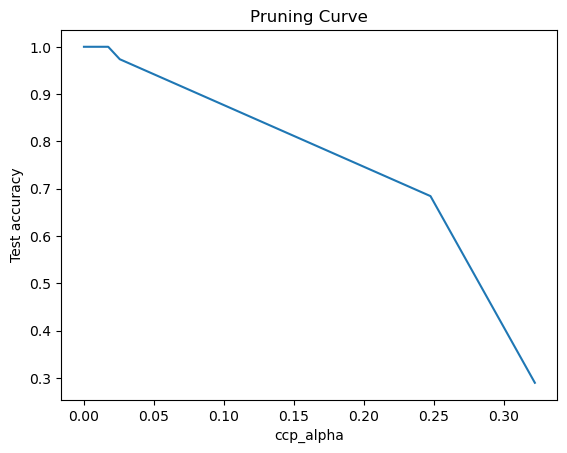

In [16]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

models = []
for ccp in ccp_alphas:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp)
    model.fit(X_train, y_train)
    models.append(model)

accs = [m.score(X_test, y_test) for m in models]

plt.plot(ccp_alphas, accs)
plt.xlabel("ccp_alpha")
plt.ylabel("Test accuracy")
plt.title("Pruning Curve")
plt.show()

## CART for Regression — Explanation (in short)

Regression Trees use **MSE impurity** to decide where to split:
- They partition the x-axis into intervals.
- In each interval the model predicts a **constant value** (mean of samples inside).

### What the plot shows:
We fit trees with different `max_depth` values to noisy sinus data.

- **depth = 1**  
  The model creates only one split and predicts two large flat segments.  
  This is **underfitting** — the tree is too simple to capture the sinus shape.

- **larger depths** (not shown here but can be added)  
  The tree creates many small intervals and follows the noise.  
  This leads to **overfitting** — the model memorizes training points instead of capturing the smooth pattern.

### Key intuition:
- Small depth → high bias, low variance (too simple).  
- Large depth → low bias, high variance (too wiggly).  
- Optimal depth sits **in the middle**, balancing smoothness and flexibility.

This example illustrates how tree depth controls overfitting in regression.


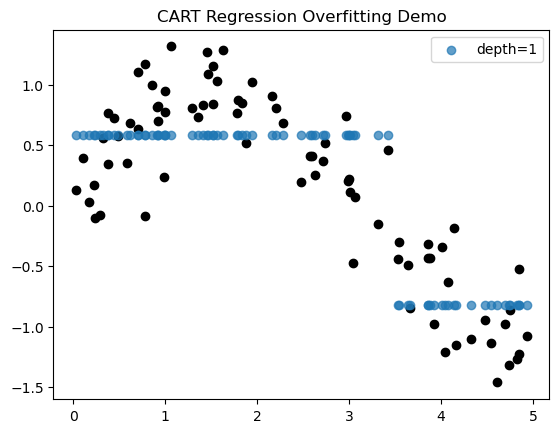

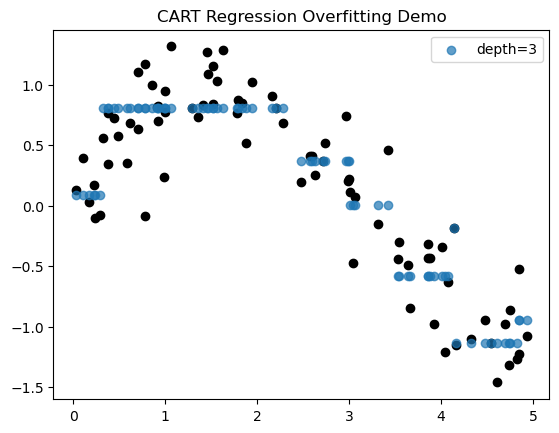

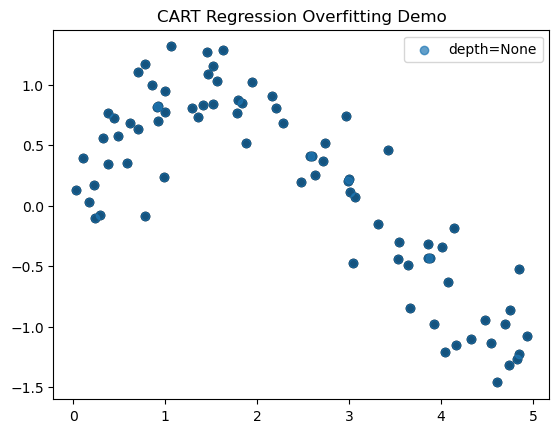

In [17]:
rng = np.random.RandomState(42)

X_reg = np.sort(5 * rng.rand(80, 1), axis=0)
y_reg = np.sin(X_reg).ravel() + rng.normal(0, 0.3, X_reg.shape[0])

for depth in [1, 3, None]:
    reg = DecisionTreeRegressor(max_depth=depth)
    reg.fit(X_reg, y_reg)
    
    plt.scatter(X_reg, y_reg, color="black")
    plt.scatter(X_reg, reg.predict(X_reg), alpha=0.7, label=f"depth={depth}")
    plt.legend()
    plt.title("CART Regression Overfitting Demo")
    plt.show()

## 1. Titanic dataset

We use a real dataset describing the passengers of the RMS Titanic.

Features include:
- `Pclass` (1st/2nd/3rd class)
- `Sex`
- `Age`
- `Fare`
- `SibSp` (siblings/spouses aboard)
- `Parch` (parents/children aboard)
- `Embarked` (port of embarkation)

Target variable:
- `Survived` (1 = yes, 0 = no)

This dataset is more realistic than Iris:
- contains categorical variables
- has missing values
- represents a real-world decision problem


In [19]:
import seaborn as sns
import pandas as pd
import numpy as np

titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## 2. Preprocessing for Decision Trees

Decision Trees can handle:
- numerical features directly
- categorical features after encoding (label encoding / ordinal encoding)

But they cannot handle:
- missing values

We will:
1. Keep a subset of useful features
2. Drop rows with missing values (for simplicity in labs)
3. Encode categorical variables

In [20]:
df = titanic[["survived", "pclass", "sex", "age", "fare", "sibsp", "parch", "embarked"]].dropna()

df.head()

,survived,pclass,sex,age,fare,sibsp,parch,embarked
0,0,3,male,22.0,7.2500,1,0,S
1,1,1,female,38.0,71.2833,1,0,C
2,1,3,female,26.0,7.9250,0,0,S
3,1,1,female,35.0,53.1000,1,0,S
4,0,3,male,35.0,8.0500,0,0,S


In [21]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
for col in ["sex", "embarked"]:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

df_encoded.head()

,survived,pclass,sex,age,fare,sibsp,parch,embarked
0,0,3,1,22.0,7.2500,1,0,2
1,1,1,0,38.0,71.2833,1,0,0
2,1,3,0,26.0,7.9250,0,0,2
3,1,1,0,35.0,53.1000,1,0,2
4,0,3,1,35.0,8.0500,0,0,2


In [22]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop("survived", axis=1)
y = df_encoded["survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train.head()

,pclass,sex,age,fare,sibsp,parch,embarked
703,3,1,25.0,7.7417,0,0,1
462,1,1,47.0,38.5000,0,0,2
858,3,0,24.0,19.2583,0,3,0
429,3,1,32.0,8.0500,0,0,2
811,3,1,39.0,24.1500,0,0,2


In [23]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7134831460674157
              precision    recall  f1-score   support

           0       0.73      0.78      0.75        99
           1       0.69      0.63      0.66        79

    accuracy                           0.71       178
   macro avg       0.71      0.71      0.71       178
weighted avg       0.71      0.71      0.71       178



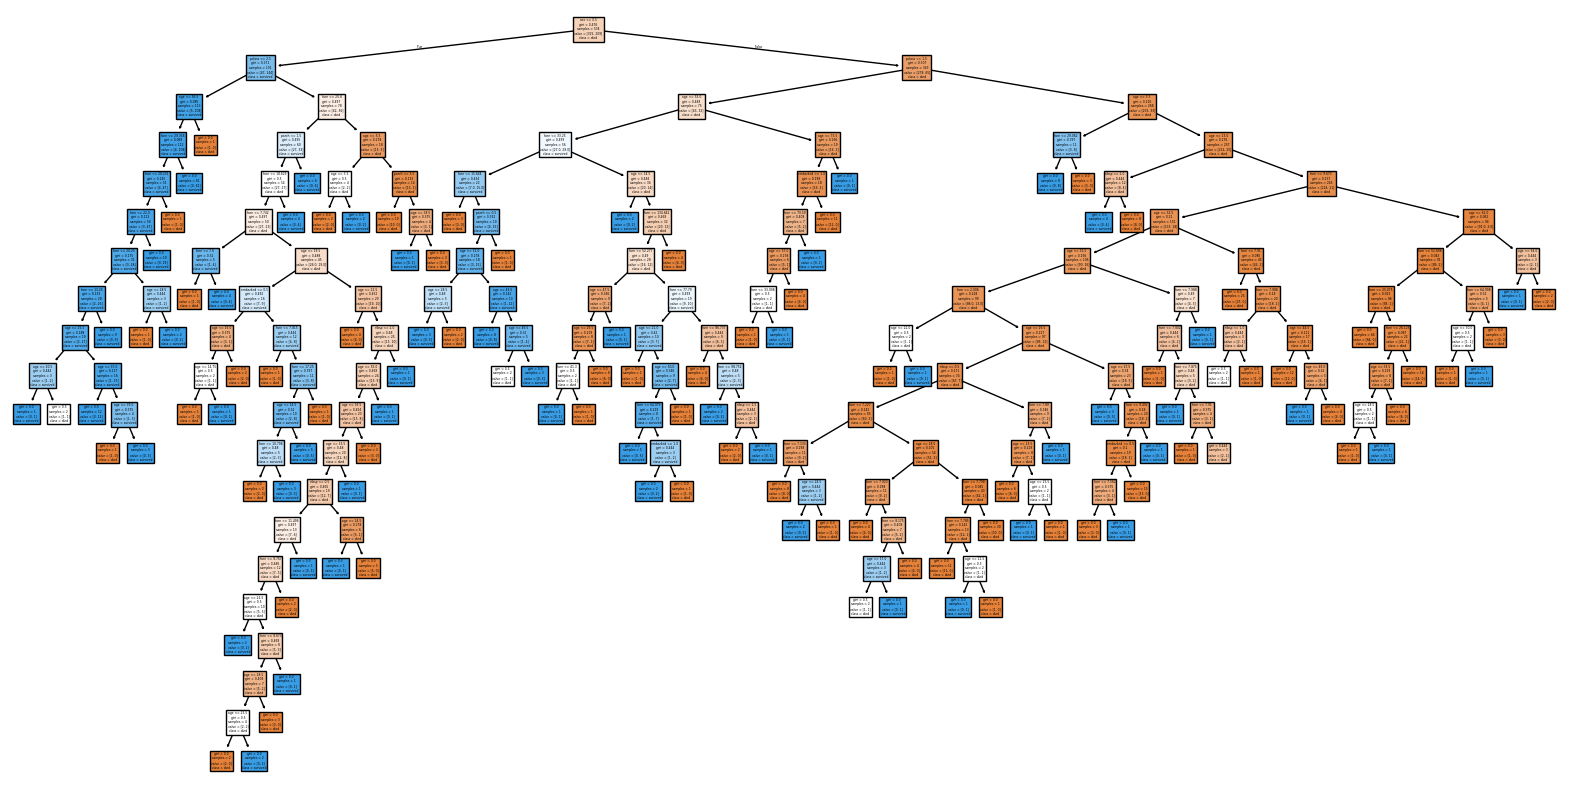

In [24]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=["died", "survived"],
    filled=True
)
plt.show()

In [25]:
clf_unrestricted = DecisionTreeClassifier(random_state=42)
clf_unrestricted.fit(X_train, y_train)

print("Train accuracy:", clf_unrestricted.score(X_train, y_train))
print("Test accuracy :", clf_unrestricted.score(X_test, y_test))

Train accuracy: 0.9906367041198502
Test accuracy : 0.7134831460674157


In [26]:
for depth in [1, 2, 3, 4, 5, None]:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(f"depth={depth}, test accuracy={acc:.3f}")

depth=1, test accuracy=0.747
depth=2, test accuracy=0.758
depth=3, test accuracy=0.719
depth=4, test accuracy=0.702
depth=5, test accuracy=0.719
depth=None, test accuracy=0.713


In [27]:
importances = clf.feature_importances_

pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

,feature,importance
1,sex,0.313840
2,age,0.271500
3,fare,0.213996
0,pclass,0.133861
4,sibsp,0.035323
5,parch,0.017557
6,embarked,0.013925


In [28]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(clf, X_test, y_test, n_repeats=20)
sorted_idx = perm.importances_mean.argsort()

for idx in sorted_idx[::-1]:
    print(f"{X.columns[idx]}: {perm.importances_mean[idx]:.4f}")

sex: 0.1244
pclass: 0.0893
age: 0.0362
sibsp: 0.0351
fare: 0.0188
parch: -0.0079
embarked: -0.0098


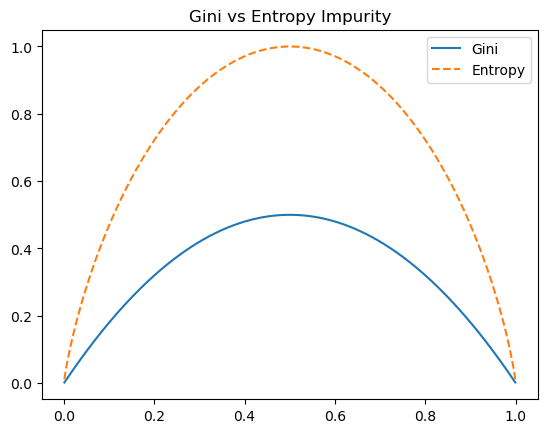

In [29]:
p = np.linspace(0.001, 0.999, 300)
gini = 2 * p * (1 - p)
entropy = -(p*np.log2(p) + (1-p)*np.log2(1-p))

plt.plot(p, gini, label="Gini")
plt.plot(p, entropy, linestyle="--", label="Entropy")
plt.legend()
plt.title("Gini vs Entropy Impurity")
plt.show()

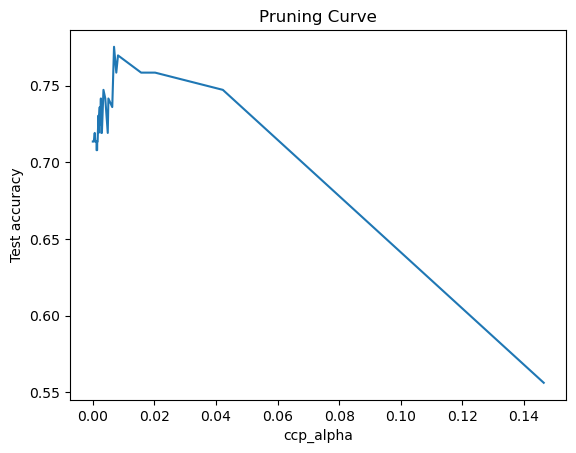

In [30]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

models = []
for ccp in ccp_alphas:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp)
    model.fit(X_train, y_train)
    models.append(model)

accs = [m.score(X_test, y_test) for m in models]

plt.plot(ccp_alphas, accs)
plt.xlabel("ccp_alpha")
plt.ylabel("Test accuracy")
plt.title("Pruning Curve")
plt.show()

### Exercise 1
Try different values for:
- `max_depth`
- `min_samples_leaf`
- `min_samples_split`

Which configuration gives the best performance?

In [31]:
from sklearn.metrics import accuracy_score

results = []

for depth in [2, 3, 4, 5, None]:
    for leaf in [1, 2, 5, 10]:
        for split in [2, 5, 10]:
            
            model = DecisionTreeClassifier(
                max_depth=depth,
                min_samples_leaf=leaf,
                min_samples_split=split,
                random_state=42
            )
            model.fit(X_train, y_train)
            acc = model.score(X_test, y_test)
            
            results.append((depth, leaf, split, acc))

df_results = pd.DataFrame(
    results,
    columns=["max_depth", "min_samples_leaf", "min_samples_split", "test_accuracy"]
).sort_values("test_accuracy", ascending=False)

df_results.head(10)

,max_depth,min_samples_leaf,min_samples_split,test_accuracy
56,NaN,5,10,0.769663
55,NaN,5,5,0.769663
54,NaN,5,2,0.769663
0,2.0,1,2,0.758427
10,2.0,10,5,0.758427
58,NaN,10,5,0.758427
57,NaN,10,2,0.758427
1,2.0,1,5,0.758427
11,2.0,10,10,0.758427
59,NaN,10,10,0.758427


### Exercise 2  
Train two decision trees:

1. `criterion="gini"`
2. `criterion="entropy"`

Compare test accuracies and comment on whether there is a meaningful difference.


In [32]:
criteria = ["gini", "entropy"]

for crit in criteria:
    model = DecisionTreeClassifier(
        criterion=crit,
        max_depth=4,
        random_state=42
    )
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(f"criterion={crit}, test_accuracy={acc:.4f}")

criterion=gini, test_accuracy=0.7022
criterion=entropy, test_accuracy=0.7303


### Exercise 3  
Compute permutation importance and compare it to impurity-based importance.

Which features truly matter most?


In [33]:
# impurity-based importance
impurity_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": clf.feature_importances_
}).sort_values("importance", ascending=False)


# permutation importance
perm = permutation_importance(
    clf, X_test, y_test, n_repeats=15, random_state=42
)
perm_importance = pd.DataFrame({
    "feature": X.columns,
    "perm_importance": perm.importances_mean
}).sort_values("perm_importance", ascending=False)


display(impurity_importance)
display(perm_importance)

,feature,importance
1,sex,0.313840
2,age,0.271500
3,fare,0.213996
0,pclass,0.133861
4,sibsp,0.035323
5,parch,0.017557
6,embarked,0.013925


,feature,perm_importance
1,sex,0.116479
0,pclass,0.082772
2,age,0.038202
4,sibsp,0.029588
3,fare,0.028464
6,embarked,-0.006367
5,parch,-0.007116


### Exercise 4  
Visualize the tree again after applying pruning (`ccp_alpha`).

Is the pruned tree smaller?  
Does it perform better, worse, or similarly?


Accuracy before pruning: 0.7134831460674157
Accuracy after pruning : 0.7191011235955056


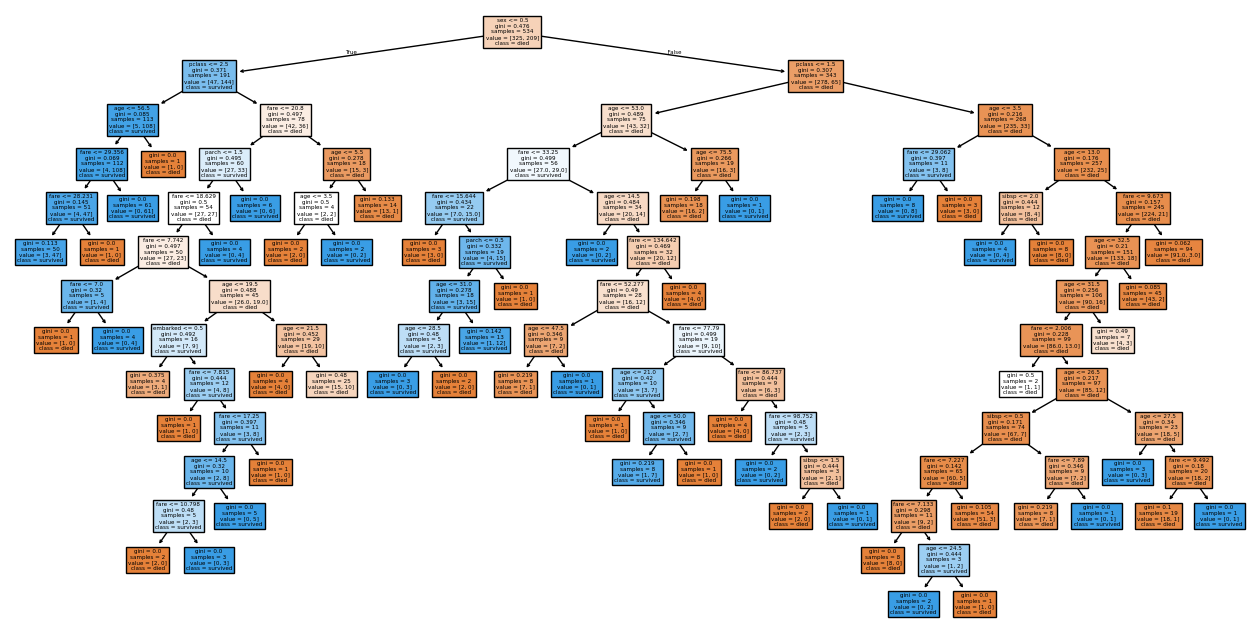

In [34]:
# get pruning alphas
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# choose a mid-range alpha (avoid extremes)
best_alpha = np.median(ccp_alphas[1:-1])

pruned = DecisionTreeClassifier(
    random_state=42, 
    ccp_alpha=best_alpha,
    max_depth=None
)
pruned.fit(X_train, y_train)

print("Accuracy before pruning:", clf.score(X_test, y_test))
print("Accuracy after pruning :", pruned.score(X_test, y_test))

# plot pruned tree
plt.figure(figsize=(16, 8))
plot_tree(
    pruned,
    feature_names=X.columns,
    class_names=["died", "survived"],
    filled=True
)
plt.show()

### Exercise 5
Plot decision boundaries using only:

- Fare  
- Age  

Does the boundary seem realistic for predicting survival on the Titanic?


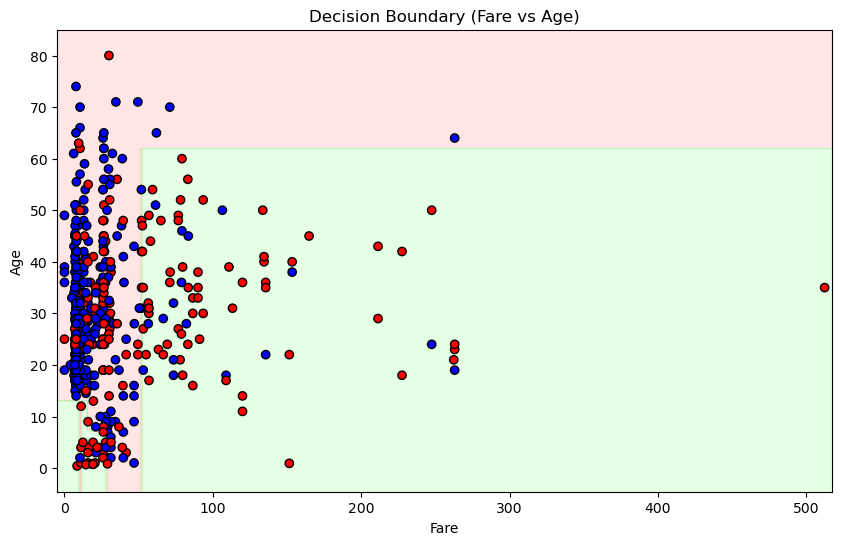

In [35]:
from matplotlib.colors import ListedColormap

# select 2D subset
X2 = df_encoded[["fare", "age"]].values
y2 = df_encoded["survived"].values

# split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, random_state=42
)

# train tree
clf_2d = DecisionTreeClassifier(max_depth=4, random_state=42)
clf_2d.fit(X2_train, y2_train)

# create grid
x_min, x_max = X2[:, 0].min() - 5, X2[:, 0].max() + 5
y_min, y_max = X2[:, 1].min() - 5, X2[:, 1].max() + 5

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)

Z = clf_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# plot decision regions
plt.figure(figsize=(10, 6))
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA"])
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

# plot data points
plt.scatter(X2_train[:, 0], X2_train[:, 1], c=y2_train, edgecolors='k', cmap="bwr")
plt.xlabel("Fare")
plt.ylabel("Age")
plt.title("Decision Boundary (Fare vs Age)")
plt.show()

# Random Forests

This notebook covers advanced Random Forest concepts for experienced ML students:

### What you will learn
- Deep mechanics of Random Forests (bagging, bootstrapping, feature subsampling)
- Hyperparameter tuning and performance diagnostics
- Out-of-Bag (OOB) vs Cross-Validation performance
- Feature importance (impurity, permutation, SHAP, interaction SHAP)
- Partial Dependence Plots (1D & 2D)
- Calibration curves and probability quality
- Tree structure diagnostics inside a forest
- Random Forest proximity matrix + anomaly detec


In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, brier_score_loss
)
from sklearn.calibration import calibration_curve

from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import shap
shap.initjs()

import warnings
warnings.filterwarnings("ignore")

## Explanation — Automatic Target Detection & Preprocessing (MAGIC Gamma dataset)

### 1. Loading the dataset
We fetch the MAGIC Gamma dataset from OpenML.  
It contains 10 numerical features + 1 **categorical target column**.

```python
magic = fetch_openml(data_id=1120, as_frame=True)
df = magic.frame.copy()

In [67]:
from sklearn.datasets import fetch_openml
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
magic = fetch_openml(data_id=1120, as_frame=True)
df = magic.frame.copy()

# ======== FIND TARGET COLUMN AUTOMATICALLY ========
# Magic Gamma target is the ONLY non-numeric column
non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
print("Detected non-numeric columns:", non_numeric_cols)

if len(non_numeric_cols) != 1:
    raise ValueError("Unexpected number of non-numeric columns. Inspect the dataset.")

target_col = non_numeric_cols[0]
print("Detected target column:", target_col)

# ======== CONVERT TARGET TO BINARY ========
df[target_col] = df[target_col].astype(str)
df["target"] = (df[target_col] == df[target_col].unique()[0]).astype(int)

# Drop original
df = df.drop(columns=[target_col])

# Split X/y
X = df.drop(columns=["target"])
y = df["target"]

print("Class distribution:")
print(y.value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train distribution:")
print(y_train.value_counts())
print("Test distribution:")
print(y_test.value_counts())

X.shape, X_train.shape, X_test.shape

Detected non-numeric columns: Index(['class:'], dtype='object')
Detected target column: class:
Class distribution:
target
1    12332
0     6688
Name: count, dtype: int64
Train distribution:
target
1    9249
0    5016
Name: count, dtype: int64
Test distribution:
target
1    3083
0    1672
Name: count, dtype: int64


((19020, 10), (14265, 10), (4755, 10))

## Baseline Random Forest
We begin with a *vanilla* model to get baseline accuracy.


Baseline Accuracy: 0.8868559411146162
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1672
           1       0.89      0.94      0.92      3083

    accuracy                           0.89      4755
   macro avg       0.89      0.86      0.87      4755
weighted avg       0.89      0.89      0.89      4755



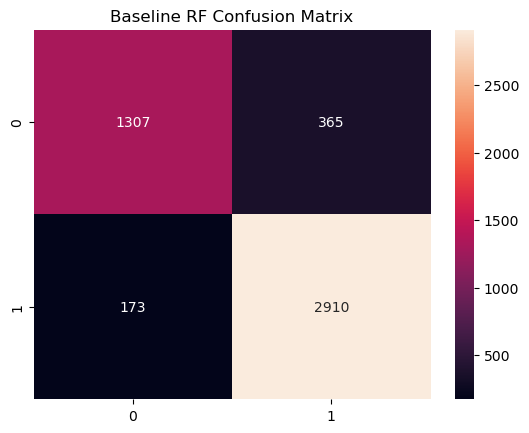

In [68]:
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train, y_train)

y_pred = rf_base.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Baseline RF Confusion Matrix")
plt.show()

## Hyperparameter Tuning (Advanced Grid)

We incorporate deeper control over:
- tree depth
- bootstrap vs no bootstrap
- feature subsampling
- min samples per leaf

We optimize for **F1-score**.


In [69]:
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [5, 10, 20, None],
    "max_features": ["sqrt", "log2", 0.3],
    "min_samples_leaf": [1, 3, 5],
    "bootstrap": [True, False]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X_train, y_train)

grid.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 200}

## Evaluate Tuned Model


Tuned RF Accuracy: 0.8853838065194533
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1672
           1       0.89      0.94      0.91      3083

    accuracy                           0.89      4755
   macro avg       0.88      0.86      0.87      4755
weighted avg       0.89      0.89      0.88      4755



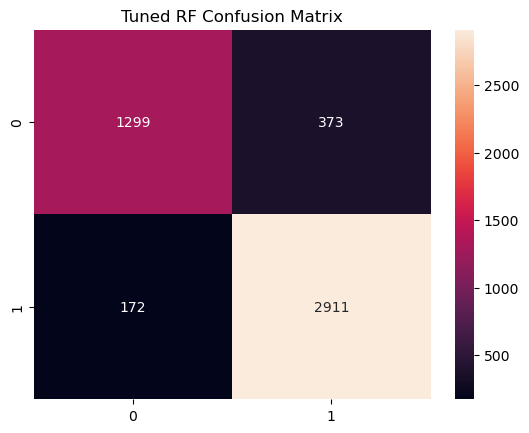

In [71]:
rf = grid.best_estimator_
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Tuned RF Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Tuned RF Confusion Matrix")
plt.show()

# Feature Importance (Three Methods)

1. Impurity-based (biased toward high-cardinality features)
2. Permutation importance (true predictive power)
3. SHAP values (global + local interpretability)


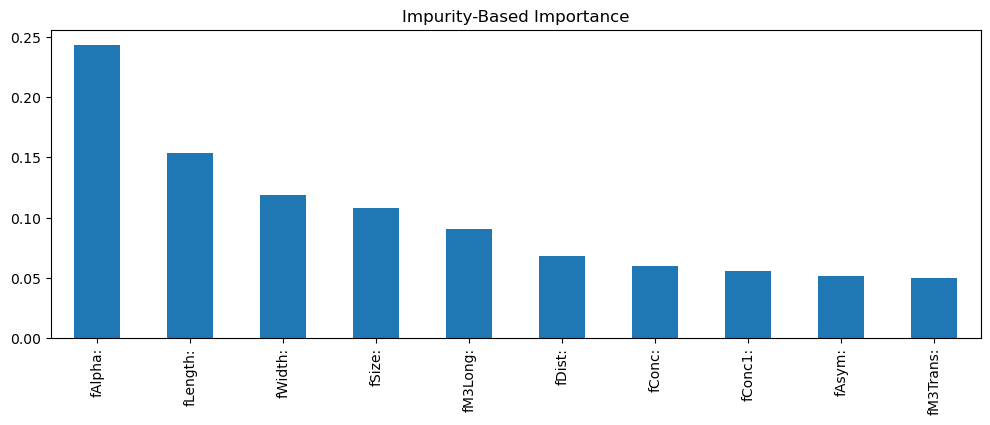

In [72]:
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
imp.plot(kind="bar", figsize=(12,4), title="Impurity-Based Importance")
plt.show()

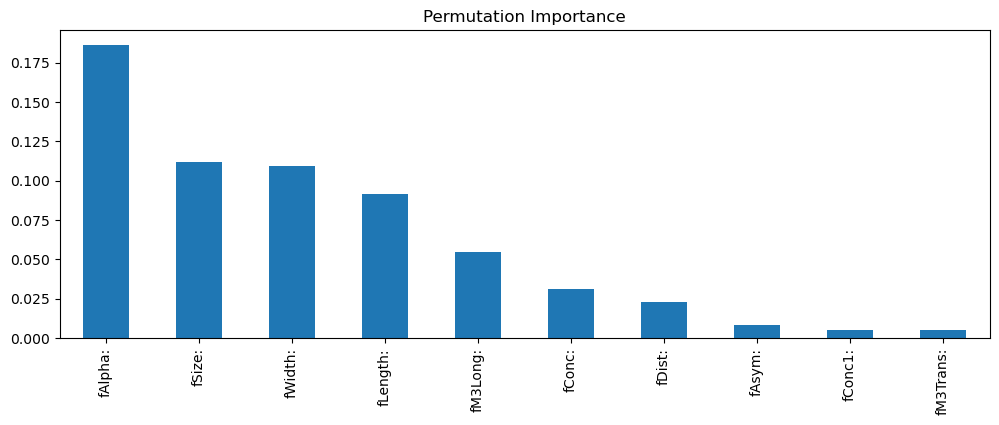

In [73]:
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_series = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

perm_series.plot(kind="bar", figsize=(12,4), title="Permutation Importance")
plt.show()

# Partial Dependence Plots (PDP)

We explore:
- 1D PDP
- 2D feature interaction PDP


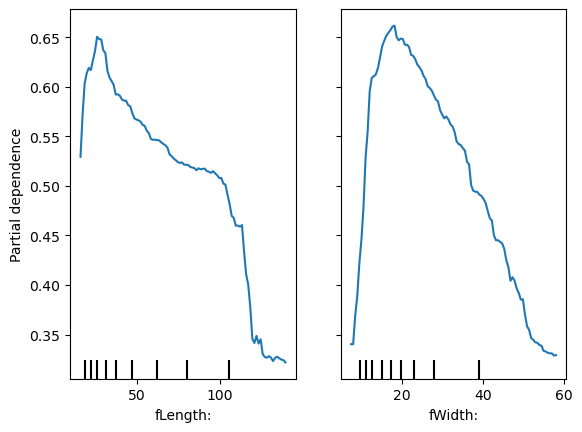

KeyboardInterrupt: 

In [74]:
features_to_plot = [0, 1]  # mean radius, mean texture

PartialDependenceDisplay.from_estimator(
    rf, X_test, features_to_plot, kind="average"
)
plt.show()

PartialDependenceDisplay.from_estimator(
    rf, X_test, [(0, 1)], kind="average"
)
plt.show()

## Calibration of Random Forest Probabilities — Explanation

Random Forests are strong classifiers, but their **predicted probabilities are often poorly calibrated**.  
This means: the predicted probability (e.g., 0.7) does not always reflect the true frequency  
(e.g., among samples with predicted 0.7, maybe only 0.5 are truly positive).

### What the code does
1. Computes predicted probabilities:  
   `probs = rf.predict_proba(X_test)[:, 1]`

2. Uses `calibration_curve()` to group predictions into bins  
   and measure how often the positive class actually occurs in each bin.

3. Plots:
   - **blue curve** → observed frequency
   - **orange dashed line** → perfect calibration (ideal model)

### How to interpret the plot
- If the blue curve lies **on the diagonal**, the model is perfectly calibrated.
- If the curve lies **below** the diagonal → model is **overconfident**  
  (predicts probabilities that are too high).
- If the curve lies **above** the diagonal → model is **underconfident**  
  (predicts probabilities that are too low).

### Interpretation for Random Forest
The plot shows deviations from the diagonal →  
Random Forest probabilities are **not perfectly calibrated**.

This happens because:
- RF averages many hard, uncalibrated decision trees.
- Trees themselves do not produce smooth probability estimates.
- Averaging them produces probabilities that are biased toward the extremes (0 or 1).

### Brier Score
`brier_score_loss(y_test, probs)`  
Measures accuracy of probability predictions.  
Lower = better calibration.

### Key takeaway
Random Forest is a strong classifier, but its probability estimates are **not reliable**  
unless calibrated (e.g., using Platt scaling or isotonic regression).


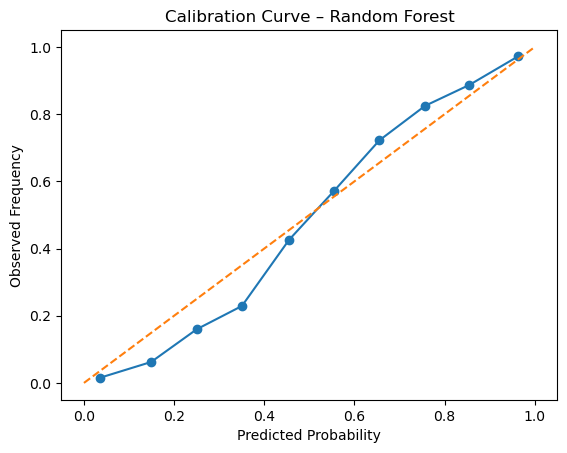

Brier Score: 0.08854738696109359


In [75]:
probs = rf.predict_proba(X_test)[:,1]
fraction_pos, mean_pred = calibration_curve(y_test, probs, n_bins=10)

plt.plot(mean_pred, fraction_pos, marker="o")
plt.plot([0,1], [0,1], "--")
plt.title("Calibration Curve – Random Forest")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.show()

print("Brier Score:", brier_score_loss(y_test, probs))

## Tree Structure Diagnostics — Explanation

Random Forest is an ensemble of decision trees.  
Although the final model is a single predictor, it is useful to inspect  
**how the individual trees behave internally**.

In this cell we analyze:

1. **Tree depth**  
   How deep each tree grows.
2. **Number of nodes**  
   How large and complex each tree is.
3. (Optional) **Feature usage**  
   How often each feature is used for splitting across all trees.

---

### Tree Depth Distribution
We extract:
```python
depths = [est.tree_.max_depth for est in rf.estimators_]


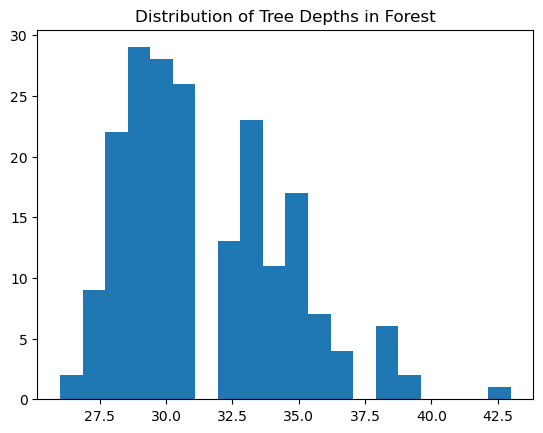

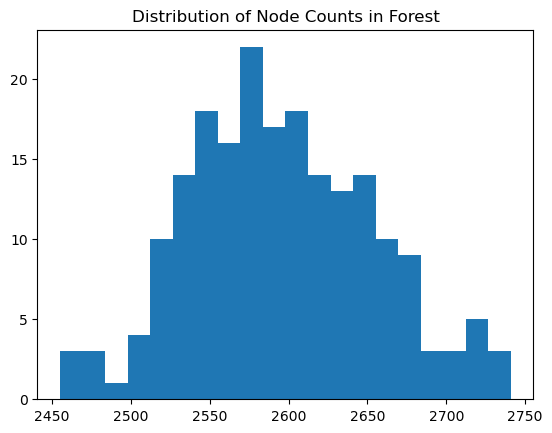

In [76]:
depths = [estimator.tree_.max_depth for estimator in rf.estimators_]
nodes = [estimator.tree_.node_count for estimator in rf.estimators_]

plt.hist(depths, bins=20)
plt.title("Distribution of Tree Depths in Forest")
plt.show()

plt.hist(nodes, bins=20)
plt.title("Distribution of Node Counts in Forest")
plt.show()

# OOB Score vs Cross-Validation


In [78]:
rf_oob = RandomForestClassifier(
    n_estimators=500, oob_score=True, bootstrap=True, random_state=42
)

rf_oob.fit(X_train, y_train)

oob = rf_oob.oob_score_
cv = cross_val_score(rf, X_train, y_train, cv=5).mean()

oob, cv

(0.8773221170697512, 0.876621100595864)

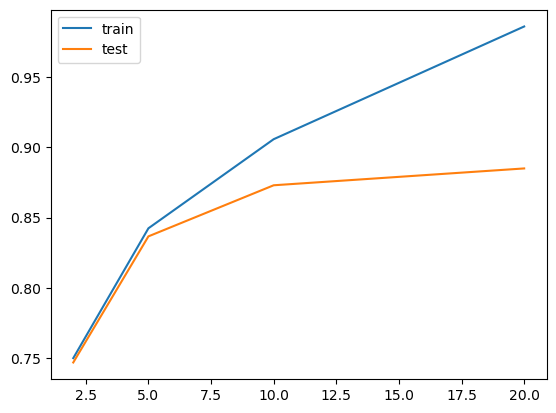

In [79]:
depths = [2, 5, 10, 20, None]
train_acc, test_acc = [], []

for d in depths:
    model = RandomForestClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    train_acc.append(model.score(X_train, y_train))
    test_acc.append(model.score(X_test, y_test))

plt.plot(depths[:-1], train_acc[:-1], label="train")
plt.plot(depths[:-1], test_acc[:-1], label="test")
plt.legend()
